In [1605]:
import numpy as np

# two d=3 qudits

In [1606]:
n_qudits = 2
d = 3

### Generate "unkown" state you want to learn

In [1607]:
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.uniform(low=-1, high=1, size=n)
    imag_part = np.random.uniform(low=-1, high=1, size=n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

psi = random_complex_vector(d**n_qudits).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [1608]:
smallest_bases = False
experimental_bases = True # also the same size as "smallest", rename eventually

zero = np.array([1, 0, 0]).reshape(-1, 1)
one = np.array([0, 1, 0]).reshape(-1, 1)
two = np.array([0, 0, 1]).reshape(-1, 1)

if smallest_bases is True:
    # Used for meeting at 4-18-25
    basis_states = []

    for i in range(d**n_qudits):
        # Direct measurements of "alpha"
        basis_vector = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
        basis_vector[i] = 1
        basis_states.append(basis_vector)

        if i > 0: # add bases for phase measurements
            basis_vector_plus = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
            basis_vector_plus[0] = 1
            basis_vector_plus[i] = 1
            basis_vector_plus *= 1/np.sqrt(2)

            basis_vector_i = basis_vector_plus.copy()
            basis_vector_i[i] *= 1j

            basis_states.append(basis_vector_plus)
            basis_states.append(basis_vector_i)
elif experimental_bases is True:
    # Rewrite with more experimentally-realistic basis
    basis_states = []

    for i in range(d**n_qudits):
        # Direct measurements of "alpha"
        basis_vector = np.zeros(d**n_qudits, dtype=np.complex128).reshape(-1, 1)
        basis_vector[i] = 1
        basis_states.append(basis_vector)

    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + np.kron(zero, one))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + 1j * np.kron(zero, one))

    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + np.kron(zero, two))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + 1j * np.kron(zero, two))

    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + np.kron(one, zero))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + 1j * np.kron(one, zero))

    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + np.kron(two, zero))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, zero) + 1j * np.kron(two, zero))

    basis_states.append(1/np.sqrt(2) * np.kron(zero, one) + np.kron(one, one))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, one) + 1j * np.kron(one, one))

    basis_states.append(1/np.sqrt(2) * np.kron(zero, one) + np.kron(two, one))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, one) + 1j * np.kron(two, one))

    basis_states.append(1/np.sqrt(2) * np.kron(zero, two) + np.kron(one, two))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, two) + 1j * np.kron(one, two))

    basis_states.append(1/np.sqrt(2) * np.kron(zero, two) + np.kron(two, two))
    basis_states.append(1/np.sqrt(2) * np.kron(zero, two) + 1j * np.kron(two, two))

else:
    zero = np.array([1, 0, 0]).reshape(-1, 1)
    one = np.array([0, 1, 0]).reshape(-1, 1)
    two = np.array([0, 0, 1]).reshape(-1, 1) 

    plus_zero_one = 1/np.sqrt(2) * np.array([1, 1, 0]).reshape(-1, 1)
    i_zero_one = 1/np.sqrt(2) * np.array([1, 1j, 0]).reshape(-1, 1)

    plus_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1]).reshape(-1, 1)
    i_zero_two = 1/np.sqrt(2) * np.array([1, 0, 1j]).reshape(-1, 1)

    basis_states = [zero, one, two,
                    plus_zero_one, i_zero_one,
                    plus_zero_two, i_zero_two]

### Create measurement projectors

In [1609]:
# 2 qubits
if smallest_bases or experimental_bases is True:
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qudit_measurement_operators = measurement_operators
else: 
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qudit_measurement_operators = []
    for qubit_1_op in measurement_operators:
        for qubit_2_op in measurement_operators:
            two_qudit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

In [1610]:
len(two_qudit_measurement_operators)

25

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [1611]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qudit_measurement_operators]

probabilities = get_probabilities(unkown_dm)

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [1612]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters. Returns a lower triangular matrix with complex elements below the diagonal
    real elements on the diagonal. """
    T = np.zeros((9, 9), dtype=np.complex_)
    index = 0 
    for i, row in enumerate(T):
        for j in range(len(row)):
            if j < i:
                T[i, j] = t[index] + 1j*t[index + 1]
                index += 2
            elif i == j:
                T[i, j] = t[index]
                index += 1
            else:
                continue

    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [1613]:
dm_parameters = np.random.uniform(low=-1, high=1, size=d**n_qudits**2)

In [1614]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [1615]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [1616]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [1617]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [1618]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [1619]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

# Density Matrix Fidelity: "Unknown" DM vs. Reconstructed DM

In [1620]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

print("Density matrix fidelity:", dm_fidelity(unkown_dm, found_dm))

Density matrix fidelity: 0.9798766495716482


### Plot Density Matrices

In [1621]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [1622]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

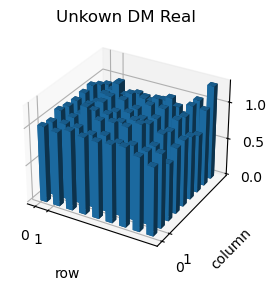

[[1.02444281 0.99858052 1.06578822 1.03716332 1.02784975 1.04694946
  1.06657499 0.99408535 0.91932444]
 [0.99858052 1.01944883 1.02099729 0.97962927 1.02131643 0.97261351
  0.99856237 0.97239549 0.99650203]
 [1.06578822 1.02099729 1.20887394 1.07668652 1.10434748 1.09476373
  1.18229994 0.94826551 0.77237382]
 [1.03716332 0.97962927 1.07668652 1.07363124 1.02077596 1.09457357
  1.09893799 1.01729007 0.88503483]
 [1.02784975 1.02131643 1.10434748 1.02077596 1.05888984 1.02429104
  1.07873049 0.96016479 0.89838906]
 [1.04694946 0.97261351 1.09476373 1.09457357 1.02429104 1.12158044
  1.12478399 1.02422645 0.85545917]
 [1.06657499 0.99856237 1.18229994 1.09893799 1.07873049 1.12478399
  1.18163515 0.98038544 0.7792374 ]
 [0.99408535 0.97239549 0.94826551 1.01729007 0.96016479 1.02422645
  0.98038544 1.0417635  1.031331  ]
 [0.91932444 0.99650203 0.77237382 0.88503483 0.89838906 0.85545917
  0.7792374  1.031331   1.26973426]]


In [1623]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

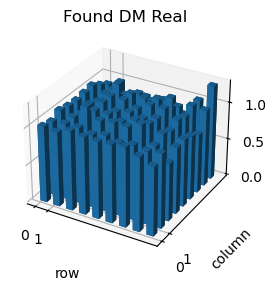

[[1.02464482 0.99857862 1.06495551 1.03696528 1.02777399 1.04740539
  1.06642772 0.99417151 0.92101854]
 [0.99857862 1.01943064 1.02074317 0.97991284 1.02115544 0.973691
  0.99870437 0.97256598 0.99679595]
 [1.06495551 1.02074317 1.20927791 1.07362798 1.10102382 1.09434817
  1.17585629 0.95048935 0.77273273]
 [1.03696528 0.97991284 1.07362798 1.07368148 1.02113429 1.09205172
  1.09848806 1.01724041 0.89066149]
 [1.02777399 1.02115544 1.10102382 1.02113429 1.05897495 1.02528475
  1.07869429 0.96093001 0.90335279]
 [1.04740539 0.973691   1.09434817 1.09205172 1.02528475 1.12174834
  1.12355787 1.0220771  0.85748352]
 [1.06642772 0.99870437 1.17585629 1.09848806 1.07869429 1.12355787
  1.18154322 0.98064164 0.79011151]
 [0.99417151 0.97256598 0.95048935 1.01724041 0.96093001 1.0220771
  0.98064164 1.04158925 1.0287126 ]
 [0.92101854 0.99679595 0.77273273 0.89066149 0.90335279 0.85748352
  0.79011151 1.0287126  1.26910941]]


In [1624]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

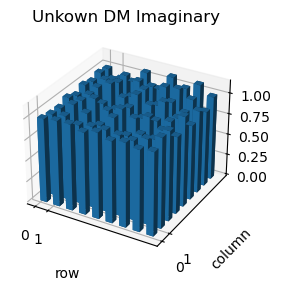

[[1.         1.02175705 1.02788145 0.97953927 1.02576479 0.97229593
  1.00272842 0.96860201 0.99080675]
 [0.97824295 1.         0.93982137 0.96810839 0.97371411 0.9598182
  0.94058179 1.00708815 1.07234486]
 [0.97211855 1.06017863 1.         0.90253809 1.03757866 0.87187966
  0.93140275 0.92223852 1.06728133]
 [1.02046073 1.03189161 1.09746191 1.         1.06248593 0.99717892
  1.05987734 0.9473108  0.91849002]
 [0.97423521 1.02628589 0.96242134 0.93751407 1.         0.91894571
  0.93293305 0.97046016 1.07456423]
 [1.02770407 1.0401818  1.12812034 1.00282108 1.08105429 1.
  1.08069843 0.93298729 0.89090207]
 [0.99727158 1.05941821 1.06859725 0.94012266 1.06706695 0.91930157
  1.         0.91514137 0.9839657 ]
 [1.03139799 0.99291185 1.07776148 1.0526892  1.02953984 1.06701271
  1.08485863 1.         0.89859283]
 [1.00919325 0.92765514 0.93271867 1.08150998 0.92543577 1.10909793
  1.0160343  1.10140717 1.        ]]


In [1625]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

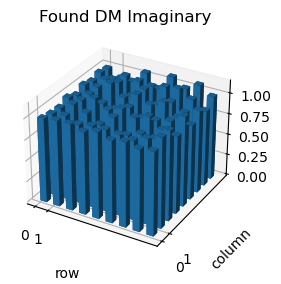

[[1.         1.02180931 1.0281135  0.97971441 1.02563721 0.97324871
  1.00279962 0.96878767 0.99066938]
 [0.97819069 1.         0.9411067  0.96826127 0.97384476 0.959783
  0.94078253 1.00694512 1.07004635]
 [0.9718865  1.0588933  1.         0.90657929 1.03697843 0.87251924
  0.93405716 0.9256603  1.06696969]
 [1.02028559 1.03173873 1.09342071 1.         1.06214876 0.99941847
  1.05942202 0.94782595 0.92371774]
 [0.97436279 1.02615524 0.96302157 0.93785124 1.         0.92121486
  0.93392977 0.97032853 1.07287551]
 [1.02675129 1.040217   1.12748076 1.00058153 1.07878514 1.
  1.07628858 0.93430127 0.89220001]
 [0.99720038 1.05921747 1.06594284 0.94057798 1.06607023 0.92371142
  1.         0.91536351 0.98669201]
 [1.03121233 0.99305488 1.0743397  1.05217405 1.02967147 1.06569873
  1.08463649 1.         0.90431705]
 [1.00933062 0.92995365 0.93303031 1.07628226 0.92712449 1.10779999
  1.01330799 1.09568295 1.        ]]


In [1626]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [1627]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [1628]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[-0.13161091+0.08438825j]
 [ 0.08275885+0.11224883j]
 [-0.25797283+0.37725848j]
 [-0.27074402+0.0181359j ]
 [-0.06100305+0.23487969j]
 [-0.34844439+0.01292097j]
 [-0.3490494 +0.2445397j ]
 [-0.07655376-0.18948092j]
 [ 0.4026535 -0.32803112j]]
prob_0 [0.02444281]
prob_1 [0.01944883]


#### original psi from density matrix, testing that it matches psi

In [1629]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.15634196+0.j         -0.00907935-0.13916319j  0.42079697-0.17833635j
  0.23770537+0.13087167j  0.17813358-0.16479766j  0.30029981+0.17720178j
  0.4258293 -0.01745164j -0.03783152+0.20082896j -0.51601992+0.05880218j]
prob_0 0.02444280758435028
prob_1 0.0194488272375341


#### statevector from reconstructed dm

In [1630]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [ 0.15814527+0.j         -0.00944316-0.13970918j  0.4223945 -0.18141662j
  0.23641564+0.12851434j  0.17698246-0.16544726j  0.30476939+0.174329j
  0.4236351 -0.01981727j -0.0362259 +0.19886907j -0.51512422+0.06000564j]
prob_0 0.02500992534382362
prob_1 0.01960782775639737


### State vector fidelity

In [1631]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [1632]:
statevector_fidelity(psi, found_psi_from_dm)

0.9999569050407693